# Drug Name Detection

In [1]:
import os
import zipfile
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pytesseract
from fuzzywuzzy import fuzz
from difflib import SequenceMatcher
import jiwer
from PIL import Image
from glob import glob

In [2]:
# Specify the path to your ZIP file and dataset directory
zip_file_path = 'Drug-Name.zip'
dataset_path = './Drug-Name/'

# Unzipping the file if it's not already unzipped
if not os.path.exists(dataset_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_path)
    print(f"Unzipped the dataset to: {dataset_path}")
else:
    print(f"Dataset already extracted at: {dataset_path}")

# Path to the 'data.yaml' file
yaml_file_path = os.path.join(dataset_path, 'data.yaml')

# Check if the YAML file exists
if os.path.exists(yaml_file_path):
    # Load the YAML file
    with open(yaml_file_path, 'r') as file:
        data_config = yaml.safe_load(file)
    
    # Print the contents of the YAML file (it typically contains class names and file paths)
    print("Contents of data.yaml:")
    print(data_config)
else:
    print("Error: data.yaml file not found.")

Dataset already extracted at: ./Drug-Name/
Contents of data.yaml:
{'train': '../train/images', 'val': '../valid/images', 'test': '../test/images', 'nc': 1, 'names': ['drug-name'], 'roboflow': {'workspace': 'kabul-university-evptq', 'project': 'drug-name-detection', 'version': 2, 'license': 'CC BY 4.0', 'url': 'https://universe.roboflow.com/kabul-university-evptq/drug-name-detection/dataset/2'}}


In [3]:
# Data Exploration and Visualization

Number of training images: 1276


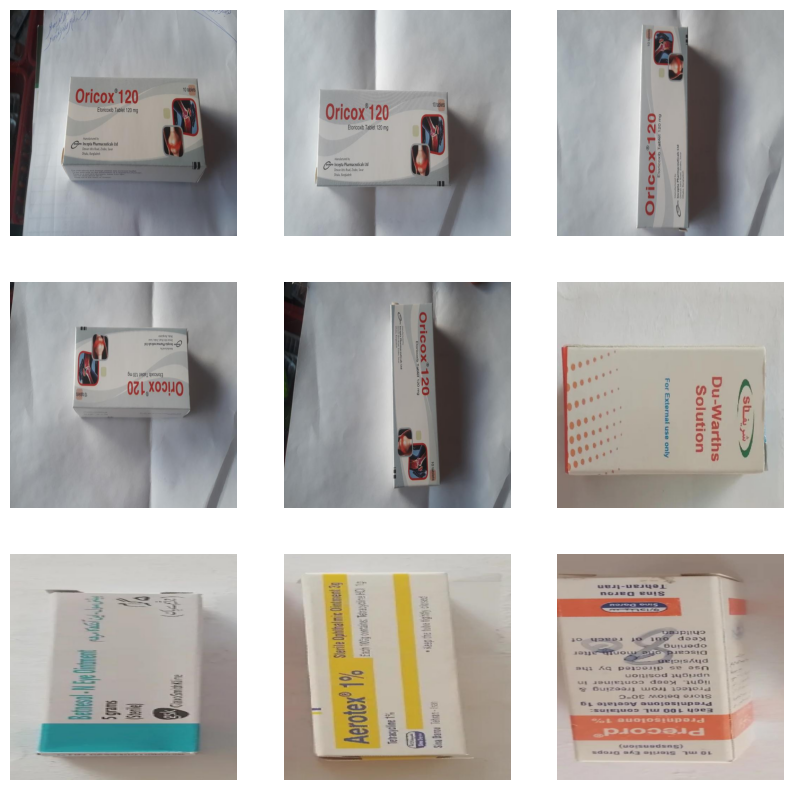

In [4]:
# Paths to train, test, valid directories based on data.yaml
train_dir = os.path.join(dataset_path, 'train', 'images')
test_dir = os.path.join(dataset_path, 'test', 'images')
valid_dir = os.path.join(dataset_path, 'valid', 'images')

# Exploring some images from the training dataset
train_images = glob(os.path.join(train_dir, "*.jpg"))  # Assuming images are in jpg format
print(f"Number of training images: {len(train_images)}")

# Display a few sample images to understand the data
plt.figure(figsize=(10, 10))
for i, img_path in enumerate(train_images[:9]):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV) to RGB (Matplotlib)
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [5]:
# EfficientDet for Object Detection

In [6]:
!pip install opencv-python tensorflow

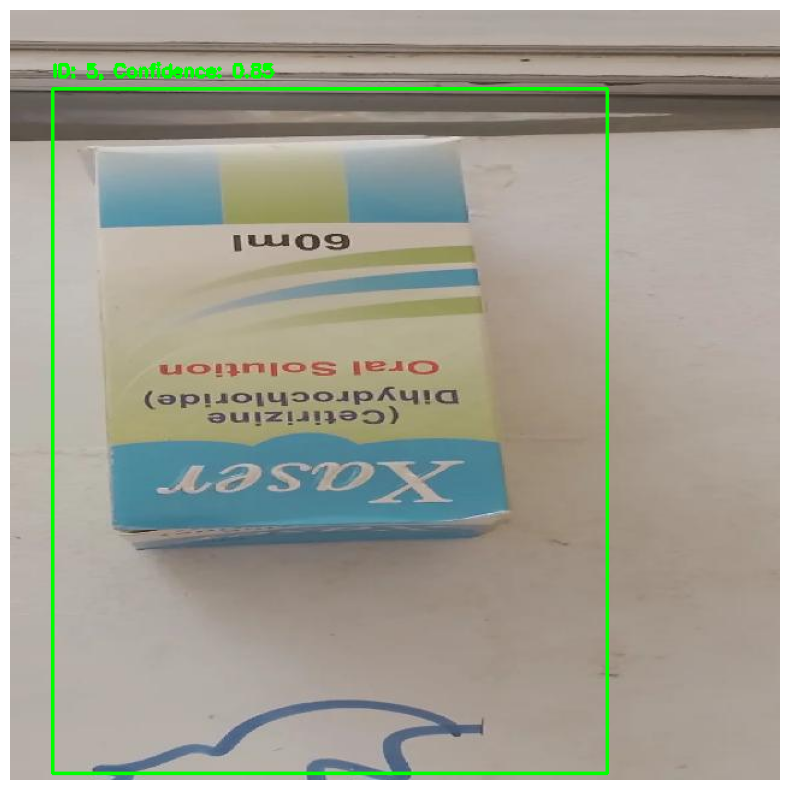

In [13]:
# Path to the pre-trained MobileNet SSD model files
prototxt_path = r'C:\Users\milto\Downloads\deploy.prototxt'  # Use raw string
model_path = r'C:\Users\milto\Downloads\mobilenet_iter_73000.caffemodel'  # Use raw string

# Load the pre-trained MobileNet SSD model from OpenCV
net = cv2.dnn.readNetFromCaffe(prototxt_path, model_path)

# Function to perform object detection on an image
def detect_objects(image_path):
    # Load the image
    img = cv2.imread(image_path)
    (h, w) = img.shape[:2]
    
    # Prepare the image for MobileNet SSD (300x300 is the required size)
    blob = cv2.dnn.blobFromImage(cv2.resize(img, (300, 300)), 0.007843, (300, 300), 127.5)
    net.setInput(blob)
    
    # Perform object detection
    detections = net.forward()
    
    # Loop over the detections and draw bounding boxes for high-confidence predictions
    for i in np.arange(0, detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        
        # Filter out weak detections by ensuring the confidence is above a threshold
        if confidence > 0.5:
            # Extract the index of the class label and the bounding box
            idx = int(detections[0, 0, i, 1])
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            
            # Draw the bounding box and label on the image
            label = f"ID: {idx}, Confidence: {confidence:.2f}"
            cv2.rectangle(img, (startX, startY), (endX, endY), (0, 255, 0), 2)
            y = startY - 10 if startY - 10 > 10 else startY + 10
            cv2.putText(img, label, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    # Convert BGR to RGB for plotting with Matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Display the image with bounding boxes
    plt.figure(figsize=(10, 10))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

# Test the detection on your test image
image_path = '8EOCEZeEqgWQdDIsEkYWKzVgiTd_jpg.rf.60114629253e31a5422925f7eb40d0ef.jpg'  # Path to your test image
detect_objects(image_path)

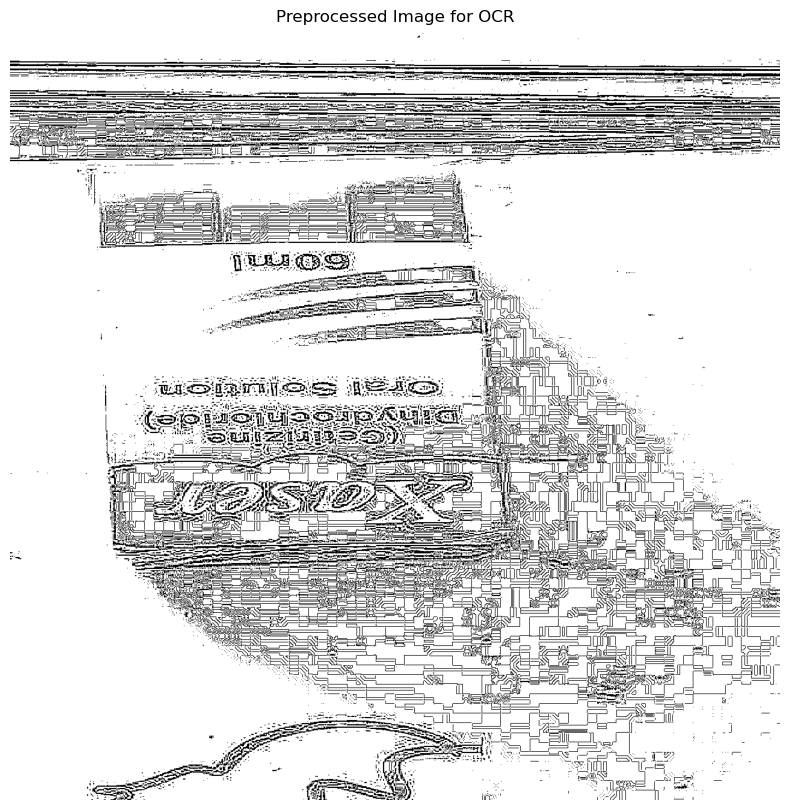

Detected Drug Name(s):
SS E
SSLEAS P
7 SPESSRT S
SS
S FS DSHS
WE
VT
SEES A
EN 8 SP



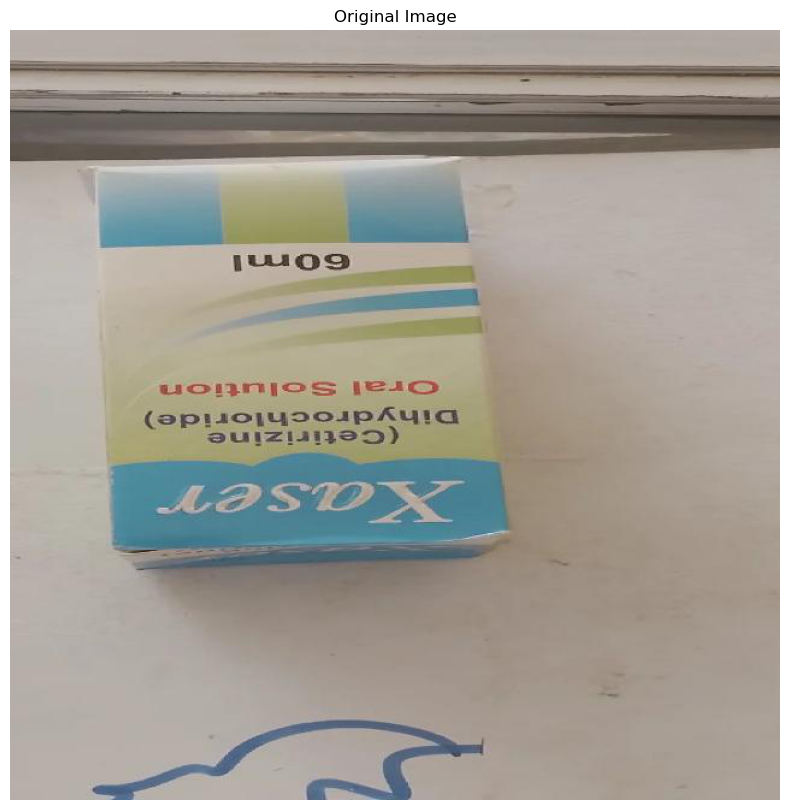

In [26]:
# Set up the Tesseract executable path (for Windows only)
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

# Function to preprocess and extract text using Tesseract OCR
def extract_text(image_path):
    # Load the image using OpenCV
    img = cv2.imread(image_path)
    
    # Convert to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Upscale the image to enhance small text
    upscale_img = cv2.resize(gray_img, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
    
    # Apply sharpening kernel
    sharpening_kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    sharpened_img = cv2.filter2D(upscale_img, -1, sharpening_kernel)
    
    # Increase contrast
    contrast_img = cv2.convertScaleAbs(sharpened_img, alpha=1.5, beta=20)  # Adjust alpha for contrast, beta for brightness
    
    # Apply adaptive thresholding
    adaptive_thresh_img = cv2.adaptiveThreshold(
        contrast_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
    )
    
    # Visualize the preprocessed image
    plt.figure(figsize=(10, 10))
    plt.imshow(adaptive_thresh_img, cmap='gray')
    plt.title('Preprocessed Image for OCR')
    plt.axis('off')
    plt.show()

    # Configure Tesseract with different PSM modes for better accuracy
    config = r'--oem 3 --psm 6 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
    
    # Use Tesseract to extract text from the preprocessed image
    extracted_text = pytesseract.image_to_string(adaptive_thresh_img, config=config)
    
    # Return the extracted text
    return extracted_text

# Test the detection on your image
image_path = '8EOCEZeEqgWQdDIsEkYWKzVgiTd_jpg.rf.60114629253e31a5422925f7eb40d0ef.jpg'  # Path to your image
text = extract_text(image_path)

# Display the extracted text
print("Detected Drug Name(s):")
print(text)

# Display the original image
img = Image.open(image_path)
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.title('Original Image')
plt.show()

In [ ]:
# It looks like the output is still not producing the correct drug names, 
# which might be due to the quality of the image or specific challenges such as complex fonts or noisy backgrounds.

Drug name not detected.


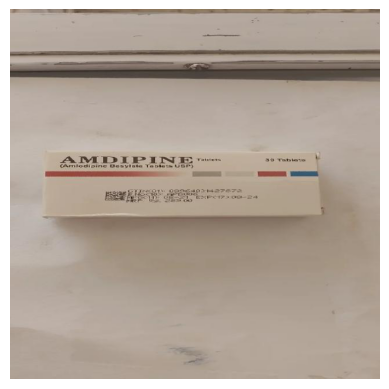

Raw Extracted Text:
See

Sees
a
ee SSS ss
Geto ae gio
pee a
ae Capt
shes 1 BaaSe ere



In [37]:
# Set up the Tesseract executable path (for Windows only)
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

# Function to extract text using Tesseract OCR with enhanced image processing
def extract_text(image_path, target_drug):
    # Load the image using OpenCV
    img = cv2.imread(image_path)
    
    # Convert to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Sharpening the image
    kernel = np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]])
    sharp_img = cv2.filter2D(gray_img, -1, kernel)
    
    # Apply adaptive thresholding to improve text detection
    thresh_img = cv2.adaptiveThreshold(sharp_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    
    # Custom config for tesseract to whitelist only alphanumeric characters
    config = r'--oem 3 --psm 6 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789'
    
    # Use Tesseract to extract text from the image
    extracted_text = pytesseract.image_to_string(thresh_img, config=config)
    
    # Fuzzy matching with a minimum similarity threshold
    def fuzzy_search(text, target, threshold=70):
        for word in text.split():
            if fuzz.ratio(word.lower(), target.lower()) > threshold:
                return word
        return None
    
    found_drug = fuzzy_search(extracted_text, target_drug)
    
    if found_drug:
        print(f"Detected Drug Name(s): {found_drug}")
    else:
        print("Drug name not detected.")
    
    # Return the extracted text for debugging purposes
    return extracted_text

# Test the detection on your image
image_path = '8PirztOrsOjfGFmLtminmUsbaRu_jpg.rf.d6efa85efc8008a4d93826ce529c3aa5.jpg'  # Replace with your image path
text = extract_text(image_path, target_drug='Amdipine')

# Display the image as well
img = Image.open(image_path)
plt.imshow(img)
plt.axis('off')
plt.show()

# Display the raw extracted text (for debugging purposes)
print("Raw Extracted Text:")
print(text)

In [42]:
def evaluate_model(ground_truth, extracted_text):
    # Fuzzy similarity score
    similarity = fuzz.ratio(ground_truth.lower(), extracted_text.lower())
    
    # Character accuracy
    matcher = SequenceMatcher(None, ground_truth, extracted_text)
    character_accuracy = matcher.ratio() * 100
    
    # Word Error Rate (WER)
    word_error_rate = jiwer.wer(ground_truth, extracted_text)
    
    return {
        "fuzzy_similarity": similarity,
        "character_accuracy": character_accuracy,
        "word_error_rate": word_error_rate
    }

# Example ground truth and extracted text
ground_truth = "Amlodipine"
extracted_text = "AMPIPINE"

# Evaluate
evaluation_results = evaluate_model(ground_truth, extracted_text)
print(evaluation_results)

{'fuzzy_similarity': 78, 'character_accuracy': 11.11111111111111, 'word_error_rate': 1.0}


In [ ]:
# Interpretation

# These results suggest that while the fuzzy similarity shows some degree of closeness to the actual drug name, 
# the detection is still quite inaccurate overall. 
# The low character accuracy and high word error rate indicate that the OCR model struggled to detect the drug name correctly.

# Possible Next Steps:

# Improving Preprocessing: You could try different preprocessing techniques such as more advanced noise reduction, adaptive thresholding, or rotation correction to improve the OCR performance.
# Custom Training or Fine-tuning: If this dataset is crucial, you might consider training or fine-tuning a model specifically for recognizing drug names, possibly using a labeled dataset.
# Post-Processing Heuristics: Implementing better post-processing, such as dictionary lookups for common drug names, could help improve the accuracy of the recognized names.